# Neural Network Denosing
# John (Jack), Quinn
## Data Driven Modeling Presentation
This is the code portion for the PSI-PDE method presentation.
See https://github.com/ymlasu/PSI-PDE for more code.

In [1]:
#!conda install -c anaconda scipy
#!conda install pytorch torchvision torchaudio -c pytorch
import scipy.io as sio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as Fun
from torch.autograd import Variable
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from torchvision import datasets
import time
start_time = time.time()
np.random.seed(seed=1)
torch.manual_seed(0)

Useful packages.

### Early Stopping Criterion
---
In order to prevent overfitting and length of training. If the validation loss does not decrease a counter is started for that epoch till a patience parameter is reached.

In [2]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Data From Matlab Files
---
If you have data from .mat files and want to use python methods for them scipy has a useful function to convert .mat files to python dictionaries. In order to then use a deep learning model the data has to be converted into torch tensors.

In [3]:
Data = sio.loadmat('dataBurgers2DN40.mat')
Data_no_noise = sio.loadmat('dataBurgers2DN0.mat')
x = Data["x"] 
y = Data["y"] 
t = Data["t"] 
u = Data["u"] 
x_no_noise = Data_no_noise["x"] 
y_no_noise = Data_no_noise["y"] 
t_no_noise = Data_no_noise["t"] 
u_no_noise = Data_no_noise["u"] 
xTrn = Data["xTrn"] 
xVal = Data["xVal"]
yTrn = Data["yTrn"] 
yVal = Data["yVal"]
tTrn = Data["tTrn"] 
tVal = Data["tVal"]  
uTrn = Data["uTrn"] 
uVal = Data["uVal"] 
# coefficients of PDE
# Data = sio.loadmat('c_pred.mat')
# c_pred = Data["c_pred"] 
# Convert numpy arrays to torch Variables
X = Variable(torch.from_numpy(x).float(),requires_grad=True)
Y = Variable(torch.from_numpy(y).float(),requires_grad=True)
T = Variable(torch.from_numpy(t).float(),requires_grad=True)
U = Variable(torch.from_numpy(u).float(),requires_grad=True)
XTrn = Variable(torch.from_numpy(xTrn).float(),requires_grad=True)
YTrn = Variable(torch.from_numpy(yTrn).float(),requires_grad=True)
TTrn = Variable(torch.from_numpy(tTrn).float(),requires_grad=True)
UTrn = Variable(torch.from_numpy(uTrn).float(),requires_grad=True)
XVal = Variable(torch.from_numpy(xVal).float(),requires_grad=True)
YVal = Variable(torch.from_numpy(yVal).float(),requires_grad=True)
TVal = Variable(torch.from_numpy(tVal).float(),requires_grad=True)
UVal = Variable(torch.from_numpy(uVal).float(),requires_grad=True)

### Hyperparameters
---

In [4]:
# Hyperparameters
# gamma: regularizer of data loss
# lmbd1: regularizer of l1 norm of model weights
# lmbd2: regularizer of l2 norm of model weights
# alpha1: regularizer of physical loss 1: PDE
# alpha2: regularizer of physical loss 2: initial condition
# alpha3: regularizer of physical loss 3: boundary condition
# alpha4: regularizer of physical loss 4: boundary condition
gamma = 1E1; 
lmbd1 = 0;
lmbd2 = 1E-10;
alpha1 = 0# 1E1
alpha2 = 0# 1E-1;
alpha3 = 0# 1E-1;
alpha4 = 0# 1E-1;
sumAlpha = alpha1+alpha2+alpha3+alpha4
batch_size = 512

### Neural Network Architecture
---

In [5]:
class MyNet1(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(MyNet1, self).__init__()
        self.fc1 = nn.Linear(D_in, H[0])
        self.fc2 = nn.Linear(H[0], H[1])
        self.fc3 = nn.Linear(H[1], H[2])
        self.fc4 = nn.Linear(H[2], D_out)
    def forward(self, x, y, t):
        xyt = torch.cat([x, y, t], dim=1)
        f = nn.Tanh()(self.fc1(xyt))
        f = nn.Tanh()(self.fc2(f))
        f = nn.Tanh()(self.fc3(f))
        f = self.fc4(f)
        return f

### Special Implementation of loss function
---
Can add regulirization terms to loss.

In [6]:
def lossCal(output,target):
    ## calculate the loss
    # data loss on training data
    data_loss = loss_fn(output,target)
    phy_loss1 = 0;
    phy_loss2 = 0;
    phy_loss3 = 0;
    phy_loss4 = 0;

    # l1 norm of weights
    reg_loss1 = None
    for param in model.parameters():
        if reg_loss1 is None:
            reg_loss1 = param.norm(1)
        else:
            reg_loss1 = reg_loss1+param.norm(1)
    # l2 norm of weights
    reg_loss2 = None
    for param in model.parameters():
        if reg_loss2 is None:
            reg_loss2 = param.norm(2)
        else:
            reg_loss2 = reg_loss2+param.norm(2)
    # total loss
    loss =  gamma*data_loss\
    +lmbd1*reg_loss1+lmbd2*reg_loss2\
    +alpha1*phy_loss1+alpha2*phy_loss2+alpha3*phy_loss3+alpha4*phy_loss4

    return loss,data_loss,phy_loss1,phy_loss2,phy_loss3,phy_loss4

### Train Function
---

In [7]:
def train_model(model, patience, n_epochs, ifEarlyS):

    if ifEarlyS==1:
        early_stopping = EarlyStopping(patience=patience, verbose=False) # , delta=1E-6
        print('Yes')

    for epoch in range(1, n_epochs + 1):
        # to track the training loss as the model trains
        train_losses = []
        # to track the validation loss as the model trains
        valid_losses = []
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        # batch processing
        permutation = torch.randperm(XTrn.size()[0])
        for i in range(0,XTrn.size()[0], batch_size):
            indI = permutation[i:i+batch_size]
            xi, yi, ti, ui = XTrn[indI], YTrn[indI], TTrn[indI], UTrn[indI]
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            U_pred = model(xi,yi,ti)
            # calculate the loss
            loss,_,_,_,_,_ = lossCal(U_pred,ui)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
        # print loss value
        if epoch%1000 == 0:
            print('loss:',epoch,loss.item())

        if ifEarlyS==1:
            ###################
            # validate the model #
            ###################
            model.eval() # prep model for evaluation
            permutation = torch.randperm(XVal.size()[0])
            for i in range(0,XVal.size()[0], batch_size):
                indI = permutation[i:i+batch_size]
                xi, yi, ti, ui = XVal[indI], YVal[indI], TVal[indI], UVal[indI]
                U_pred_Val = model(xi,yi,ti)
                # calculate the loss
                _,data_loss,_,_,_,_ = lossCal(U_pred_Val,ui)
                # record validation loss
                valid_losses.append(loss.item())

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        epoch_len = len(str(n_epochs))
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        print(print_msg)

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        if ifEarlyS==1:
            early_stopping(valid_loss, model)
            
            if early_stopping.early_stop:
                print("Early stopping")
                break
    
    if ifEarlyS==1:
        # load the last checkpoint with the best model
        model.load_state_dict(torch.load('checkpoint.pt'))


    return model

### Choose Hyper Parameters and Train
---

In [13]:
# D_in is input dimension;
# H is the dimension of the hidden layers
# D_out is output dimension.
D_in, H, D_out =  3, [50, 100, 500, 100, 50], 1

# Construct our model by instantiating the class defined above
model = MyNet1(D_in, H, D_out)
# Define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

patience = 15
n_epochs = 20000
ifEarlyS = 1    # set it to zero if with only physics loss
model = train_model(model,patience,n_epochs,ifEarlyS)

Yes
[    1/20000] train_loss: 0.00434 valid_loss: 0.00149
[    2/20000] train_loss: 0.00151 valid_loss: 0.00188
EarlyStopping counter: 1 out of 15
[    3/20000] train_loss: 0.00143 valid_loss: 0.00132
[    4/20000] train_loss: 0.00136 valid_loss: 0.00131
[    5/20000] train_loss: 0.00128 valid_loss: 0.00123
[    6/20000] train_loss: 0.00120 valid_loss: 0.00116
[    7/20000] train_loss: 0.00108 valid_loss: 0.00095
[    8/20000] train_loss: 0.00096 valid_loss: 0.00079
[    9/20000] train_loss: 0.00083 valid_loss: 0.00070
[   10/20000] train_loss: 0.00075 valid_loss: 0.00073
EarlyStopping counter: 1 out of 15
[   11/20000] train_loss: 0.00067 valid_loss: 0.00067
[   12/20000] train_loss: 0.00059 valid_loss: 0.00066
[   13/20000] train_loss: 0.00051 valid_loss: 0.00051
[   14/20000] train_loss: 0.00046 valid_loss: 0.00044
[   15/20000] train_loss: 0.00043 valid_loss: 0.00047
EarlyStopping counter: 1 out of 15
[   16/20000] train_loss: 0.00040 valid_loss: 0.00032
[   17/20000] train_loss: 0

### Graph Results
---

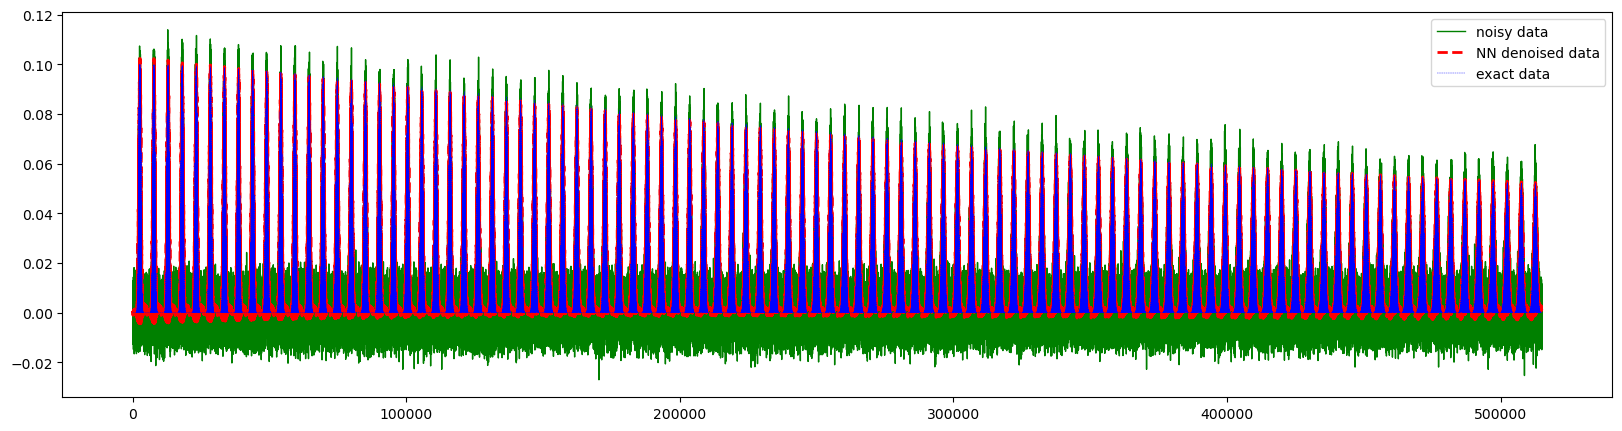

In [14]:
model.eval()
U_pred = model(X,Y,T)
u_pred = U_pred.detach().numpy()

sio.savemat('Burgers2DNN_N40.mat',{'u_pred':u_pred})

fig = plt.figure(figsize=(20,5))
plt.plot(u,'g-', linewidth=1,label = "noisy data")
plt.plot(u_pred,'r--', linewidth=2,label = "NN denoised data")
plt.plot(u_no_noise,'b--', linewidth=0.3,label = "exact data")
plt.legend()
plt.show() 

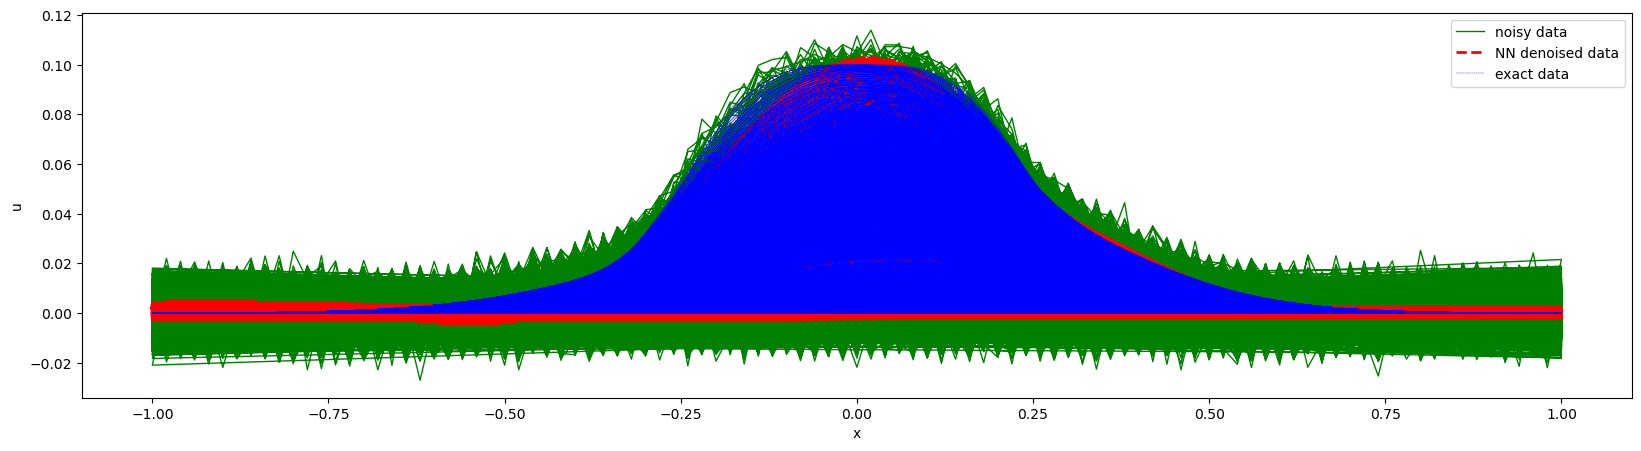

In [15]:
fig = plt.figure(figsize=(20,5))
plt.plot(x,u,'g-', linewidth=1,label = "noisy data")
plt.plot(x,u_pred,'r--', linewidth=2,label = "NN denoised data")
plt.plot(x,u_no_noise,'b--', linewidth=0.3,label = "exact data")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.show() 

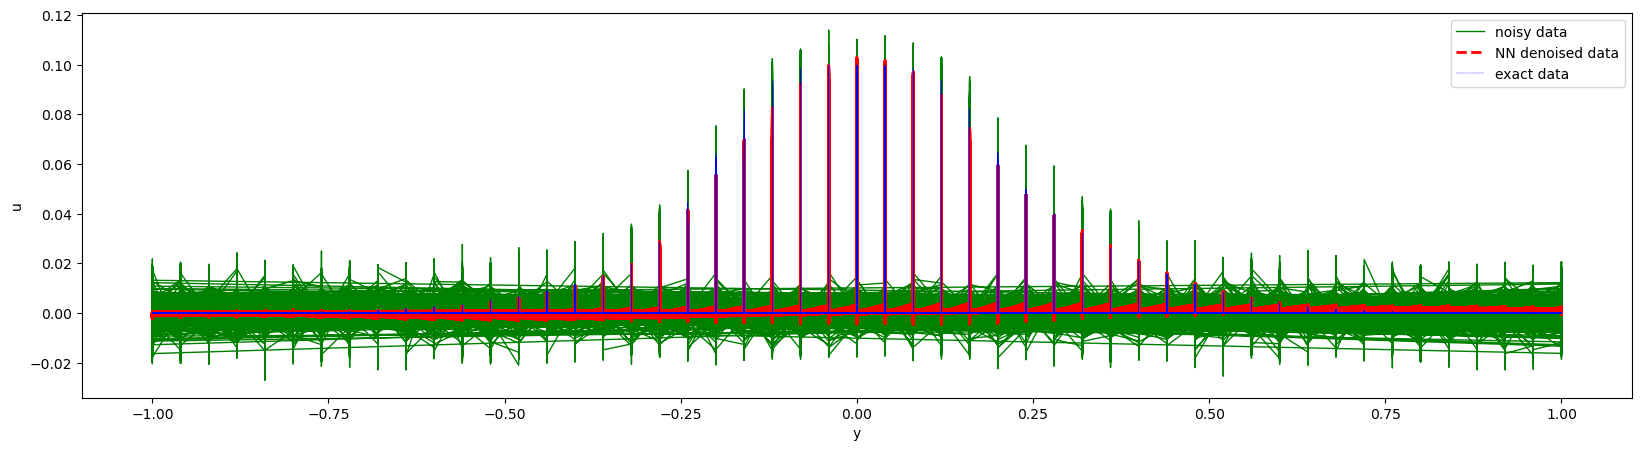

In [16]:
fig = plt.figure(figsize=(20,5))
plt.plot(y,u,'g-', linewidth=1,label = "noisy data")
plt.plot(y,u_pred,'r--', linewidth=2,label = "NN denoised data")
plt.plot(y,u_no_noise,'b--', linewidth=0.3,label = "exact data")
plt.xlabel("y")
plt.ylabel("u")
plt.legend()
plt.show() 

In [17]:
noise_diff=0
denoised_diff=0
for i,val in enumerate(u_no_noise):
    noise_diff+=np.abs(val-u[i])
    denoised_diff+=np.abs(val-u_pred[i])
noise_diff/=len(u_no_noise)
denoised_diff/=len(u_no_noise)
final_val=noise_diff/denoised_diff
print(final_val[0] , "times increase in accuracy from NN denoising")

3.784054171408288 times increase in accuracy from NN denoising
